<span style="font-size: 48px; font-weight: bold;">Algorytm SMAC testowany na zbiorze Fashion-MNIST</span>

Spis treści

- [1](#1)- Zainstalowanie wymaganych pakietów
- [2](#2) - Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow
- [3](#3) - Załadowanie danych
- [4](#4) - Ocena zbalansowania zbioru
- [5](#5) - Normalizacja danych
- [6](#6)- Zdefiniowanie CNN
- [7](#7) - Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście
- [8](#8) - Zdefiniowa funkcji celu
- [9](#9) - Zdefiniowanie parametrów startowych
- [10](#10) - Wykonujemy proces optymalizacji bayesowskiej za pomocą funkcji forest_optimize
- [11](#11) - Wyświetlenie najlepszych wyników
- [12](#12) - Wykres konwergencji
- [13](#13) - Wykres wartość funkcji celu w każdej iteracji
- [14](#14) - Wykres plot_objective
- [15](#15) - Wykres plot evaluations
- [16](#16) - Macierz pomyłek
- [17](#17) - Ocena modelu na zbiorze testowym

### <a name='1'></a> 1. Zainstalowanie wymaganych pakietów

In [28]:
# !pip install scikit-learn
# !pip install scikit-optimize
# !pip install keras
# !pip install numpy

### <a name="2"></a> 2. Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow

In [29]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D,MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

import tensorflow as tf


In [30]:
import time


### <a name="3"></a> 3.Załadowanie danych


In [31]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [32]:
type(y_train)

numpy.ndarray

### <a name="4"></a> 4.Ocena zbalansowania zbioru

Text(0, 0.5, 'Number of images')

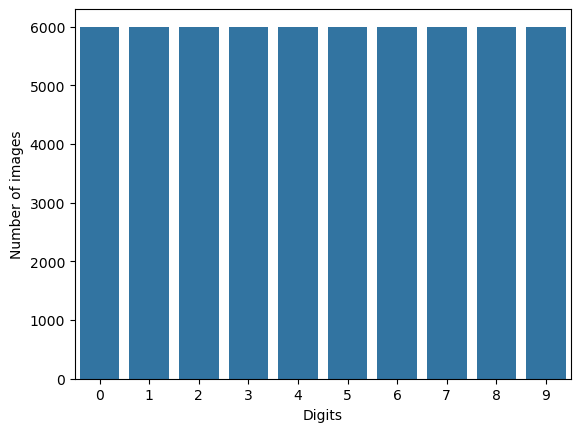

In [33]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

### <a name="5"></a> 5. Normalizacja danych

In [34]:
X_train = X_train / 255
X_test = X_test / 255

X_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
X_test = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
y_train = pd.DataFrame(y_train, columns=['label'])
y_test = pd.DataFrame(y_test, columns=['label'])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [35]:
type(X_train)

numpy.ndarray

### <a name="6"></a> 6.Zdefiniowanie CNN

In [36]:
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hiperparametry:
    learning_rate: Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw gęstych.
    num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
    activation: Funkcja aktywacji dla wszystkich warstw.
    """

    model = Sequential()

    model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    

    model.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten()) 

    
    for i in range(num_dense_layers):

        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))


    model.add(Dense(10, activation='sigmoid')) 

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

### <a name="7"></a> 7.Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście

In [37]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=10, high=500, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)

param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

### <a name="8"></a> 8.Zdefiniowa funkcji celu

In [38]:
# model zapisany pod nazwą
path_best_model = 'cnn_model.h5'

# punkt startowy dla optymalizacji
best_accuracy = 0



@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):

    """
    Hiperparametry:
    learning_rate:    Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw w pełni połączonych (dense).
    num_dense_nodes:  Liczba neuronów w każdej warstwie dense.
    activation:       Funkcja aktywacji dla wszystkich warstw.
    """

    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()

    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)


    """
    Callback do redukcji współczynnika uczenia
    Automatycznie zmniejsza współczynnik uczenia (learning_rate) o factor=0.5, jeśli
    val_accuracy (dokładność na zbiorze walidacyjnym) nie poprawi się przez patience=2 epoki.
    Minimalny współczynnik uczenia to min_lr=0.00001."""
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)

    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=5,
                        batch_size=32,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    accuracy = history.history['val_accuracy'][-1]

    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy

    if accuracy > best_accuracy:
        model.save(path_best_model)

        best_accuracy = accuracy 
    del model

    return -accuracy

### <a name="9 "></a> 9. Zdefiniowanie defaltowych parametrów

In [39]:
default_parameters = [1e-5, 1, 16, 'relu']

### <a name="10"></a> 10. Wykonujemy proces optymalizacji bayesowskiej za pomocą funkcji forest_optimize


In [40]:
start_time = time.perf_counter() 
fm_ = forest_minimize(
    objective,  
    param_grid,
    x0=default_parameters,  
    acq_func='EI', 
    n_calls=100, 
    random_state=0,
)
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1183 - loss: 0.5011 - val_accuracy: 0.2597 - val_loss: 0.3512 - learning_rate: 1.0000e-05
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2653 - loss: 0.3385 - val_accuracy: 0.3415 - val_loss: 0.2944 - learning_rate: 1.0000e-05
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3614 - loss: 0.2842 - val_accuracy: 0.4095 - val_loss: 0.2506 - learning_rate: 1.0000e-05
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4246 - loss: 0.2439 - val_accuracy: 0.5455 - val_loss: 0.2154 - learning_rate: 1.0000e-05
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5594 - loss: 0.2117 - val_accuracy: 0.6138 - val_loss: 0.1923 - learning_rate: 1.0000e-05



Accuracy: 61.38%

learning rate: 2.4e-04
num_dense_layers: 1
num_dense_nodes: 333
activation: sigmoid

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.3600 - loss: 0.2577 - val_accuracy: 0.7783 - val_loss: 0.1092 - learning_rate: 2.3517e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7843 - loss: 0.1039 - val_accuracy: 0.8193 - val_loss: 0.0874 - learning_rate: 2.3517e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8269 - loss: 0.0853 - val_accuracy: 0.8432 - val_loss: 0.0757 - learning_rate: 2.3517e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8523 - loss: 0.0738 - val_accuracy: 0.8560 - val_loss: 0.0713 - learning_rate: 2.3517e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8668 - loss: 0.0666 - val_accuracy: 0.8625 - val_loss: 0.0674 - learning_rate: 2.3517e-04



Accuracy: 86.25%

learning rate: 2.4e-03
num_dense_layers: 4
num_dense_nodes: 287
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7199 - loss: 0.1272 - val_accuracy: 0.8727 - val_loss: 0.0618 - learning_rate: 0.0024
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8878 - loss: 0.0558 - val_accuracy: 0.8925 - val_loss: 0.0540 - learning_rate: 0.0024
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9031 - loss: 0.0482 - val_accuracy: 0.8997 - val_loss: 0.0491 - learning_rate: 0.0024
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9146 - loss: 0.0426 - val_accuracy: 0.8980 - val_loss: 0.0519 - learning_rate: 0.0024
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9205 - loss: 0.0404 - val_accuracy: 0.9090 - val_loss: 0.0457 - learning_rate: 0.0024



Accuracy: 90.90%

learning rate: 1.5e-05
num_dense_layers: 1
num_dense_nodes: 98
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4477 - loss: 0.3272 - val_accuracy: 0.7422 - val_loss: 0.1339 - learning_rate: 1.5493e-05
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7550 - loss: 0.1288 - val_accuracy: 0.7760 - val_loss: 0.1139 - learning_rate: 1.5493e-05
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7816 - loss: 0.1117 - val_accuracy: 0.7987 - val_loss: 0.1033 - learning_rate: 1.5493e-05
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7997 - loss: 0.1035 - val_accuracy: 0.8110 - val_loss: 0.0973 - learning_rate: 1.5493e-05
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8149 - loss: 0.0964 - val_accuracy: 0.8133 - val_loss: 0.0928 - learning_rate: 1.5493e-05

Accuracy: 81.33%

learning rate: 8.1e-05
num_dense_layers: 1
num_dense_nodes: 347
activation: sigmoid

Epoch 


Accuracy: 91.70%

learning rate: 1.6e-03
num_dense_layers: 4
num_dense_nodes: 157
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7309 - loss: 0.1259 - val_accuracy: 0.8393 - val_loss: 0.0749 - learning_rate: 0.0016
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8945 - loss: 0.0523 - val_accuracy: 0.8973 - val_loss: 0.0514 - learning_rate: 0.0016
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9134 - loss: 0.0433 - val_accuracy: 0.8920 - val_loss: 0.0537 - learning_rate: 0.0016
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9200 - loss: 0.0388 - val_accuracy: 0.9033 - val_loss: 0.0501 - learning_rate: 0.0016
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9288 - loss: 0.0350 - val_accuracy: 0.9070 - val_loss: 0.0469 - learning_rate: 0.0016

Accuracy: 90.70%

learning rate: 3.6e-04
num_dense_layers: 2
num_dense_nodes: 195
activation: sigmoid

Epoch 1/5
1688/1688 ━━━━━


Accuracy: 91.75%

learning rate: 4.0e-04
num_dense_layers: 1
num_dense_nodes: 290
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7428 - loss: 0.1310 - val_accuracy: 0.8715 - val_loss: 0.0655 - learning_rate: 3.9790e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8851 - loss: 0.0596 - val_accuracy: 0.8923 - val_loss: 0.0553 - learning_rate: 3.9790e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9030 - loss: 0.0493 - val_accuracy: 0.9035 - val_loss: 0.0481 - learning_rate: 3.9790e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9161 - loss: 0.0431 - val_accuracy: 0.9113 - val_loss: 0.0452 - learning_rate: 3.9790e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9255 - loss: 0.0384 - val_accuracy: 0.9137 - val_loss: 0.0427 - learning_rate: 3.9790e-04

Accuracy: 91.37%

learning rate: 2.2e-04
num_dense_layers: 1
num_dense_nodes: 29
activation: relu

Epoch 1/5


Accuracy: 92.17%

learning rate: 3.4e-04
num_dense_layers: 2
num_dense_nodes: 416
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7238 - loss: 0.1339 - val_accuracy: 0.8742 - val_loss: 0.0627 - learning_rate: 3.3872e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8797 - loss: 0.0594 - val_accuracy: 0.8913 - val_loss: 0.0543 - learning_rate: 3.3872e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9030 - loss: 0.0481 - val_accuracy: 0.9013 - val_loss: 0.0484 - learning_rate: 3.3872e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9194 - loss: 0.0406 - val_accuracy: 0.9033 - val_loss: 0.0454 - learning_rate: 3.3872e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9271 - loss: 0.0362 - val_accuracy: 0.9090 - val_loss: 0.0464 - learning_rate: 3.3872e-04

Accuracy: 90.90%

learning rate: 3.1e-04
num_dense_layers: 2
num_dense_nodes: 410
activation: relu

Epoch 1/

### <a name="11"></a> 11. Wyświetlenie najlepszych wyników

- **Dokładność (accuracy):** wyświetlenie najlepszej osiągniętej dokładności.
- **Najlepsze hiperparametry:** wyświetlenie optymalnych wartości hiperparametrów.
- **Przestrzeń poszukiwań (gp_space):** analiza przestrzeni hiperparametrów.

In [41]:
"Najlepsza dokładność=%.4f" % fm_.fun

'Najlepsza dokładność=-0.9217'

In [43]:
print("""Najlepsze hiperparametry:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (fm_.x[0],
                        fm_.x[1],
                        fm_.x[2],
                        fm_.x[3],
                        
    ))

Najlepsze hiperparametry:
- learning rate=0.000395
- num_dense_layers=2
- num_nodes=418
- activation = relu


In [44]:
fm_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='identity'),
       Integer(low=1, high=5, prior='uniform', transform='identity'),
       Integer(low=10, high=500, prior='uniform', transform='identity'),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

### <a name="12"></a> 12. Wykres konwergencji




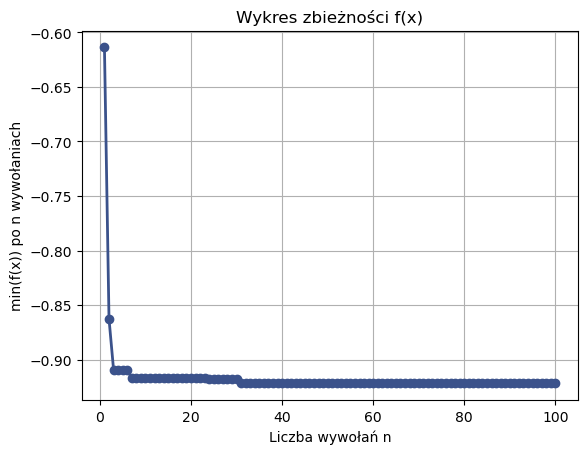

In [45]:
fig = plot_convergence(fm_)

plt.title("Wykres zbieżności f(x)")
plt.xlabel("Liczba wywołań n")
plt.ylabel("min(f(x)) po n wywołaniach")

fig.figure.savefig('wykres_zbieznosci.jpg', format='jpg', dpi=300)

plt.show()

In [46]:

iterations = range(len(fm_.func_vals))  
losses = fm_.func_vals                 
cumulative_min = np.minimum.accumulate(losses) 

data_to_save = np.column_stack((iterations, losses, cumulative_min))

file_path = "convergence_data.txt"
np.savetxt(file_path, data_to_save, delimiter=',', header="Iteration,Loss,Cumulative_Min", fmt='%.6f', comments='')

print(f"Dane zapisano do pliku: {file_path}")

Dane zapisano do pliku: convergence_data.txt


### <a name="13"></a> 13. Wykres wartość funkcji celu w każdej iteracji

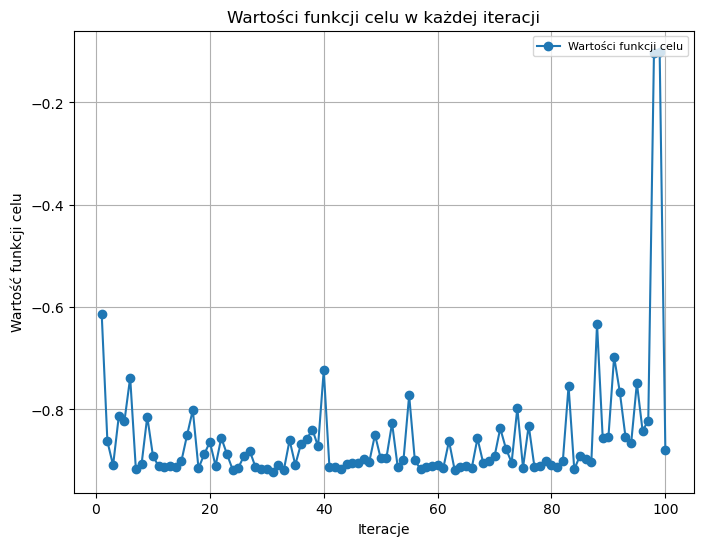

In [47]:

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(fm_.func_vals) + 1), fm_.func_vals, marker='o', label='Wartości funkcji celu')
plt.xlabel("Iteracje")
plt.ylabel("Wartość funkcji celu")
plt.title("Wartości funkcji celu w każdej iteracji")
plt.grid()
plt.legend(loc='upper right', fontsize=8)
plt.savefig('wyniki_funkcji_celu.png', dpi=300, bbox_inches='tight')

plt.show()

In [48]:

iterations = range(1, len(fm_.func_vals) + 1) 
losses = fm_.func_vals                        

data_to_save = np.column_stack((iterations, losses))

file_path = "function_values.txt"
np.savetxt(file_path, data_to_save, delimiter=',', header="Iteration,Loss", fmt='%d,%.6f', comments='')

print(f"Dane zapisano do pliku: {file_path}")

Dane zapisano do pliku: function_values.txt


### <a name="14"></a> 14.Wykres plot_objective

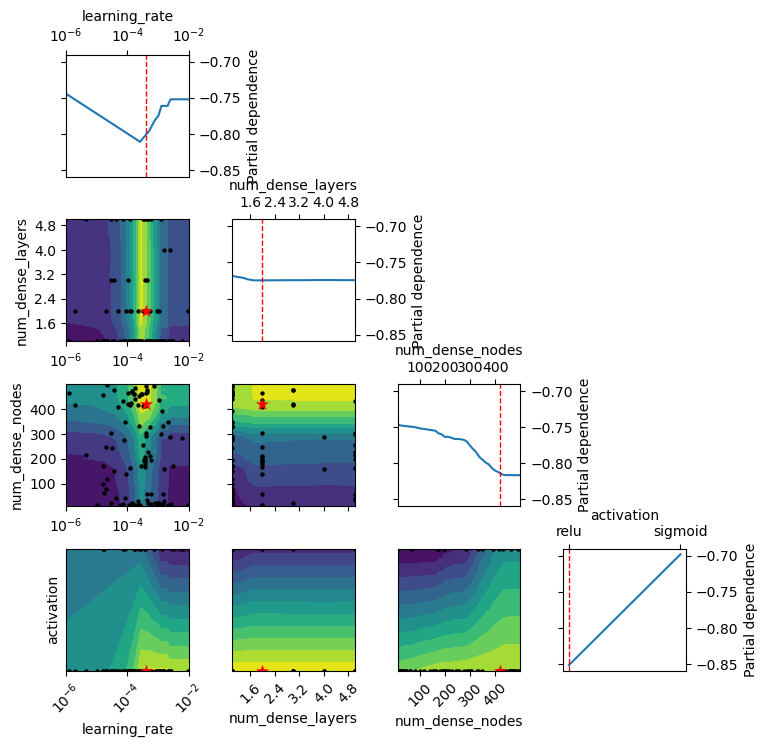

In [50]:
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'activation']
fig2=plot_objective(result=fm_, plot_dims=dim_names)
plt.show()
fig2.figure.savefig('plot_objective.jpg', format='jpg', dpi=300)



### <a name="15"></a> 15.Wykres plot evaluations

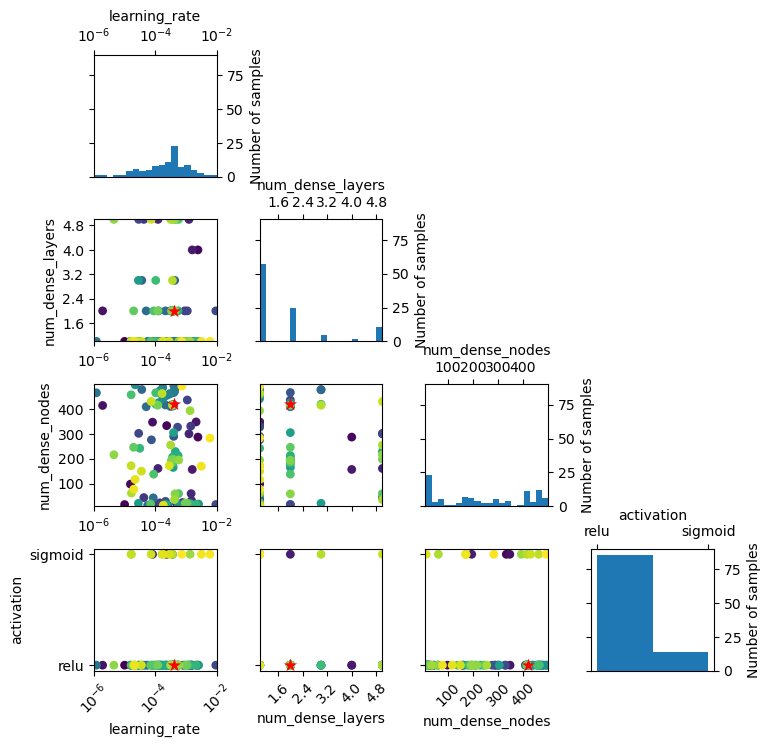

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [51]:
fig3=plot_evaluations(result=fm_, plot_dims=dim_names)
plt.show()
model = load_model('cnn_model.h5')
fig3.figure.savefig('plot_evaluations.jpg', format='jpg', dpi=300)
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis = 1)

y_true = np.argmax(y_test, axis = 1)

cm = confusion_matrix(y_true, y_pred_classes)



### <a name="16"></a> 16. Macierz pomyłek

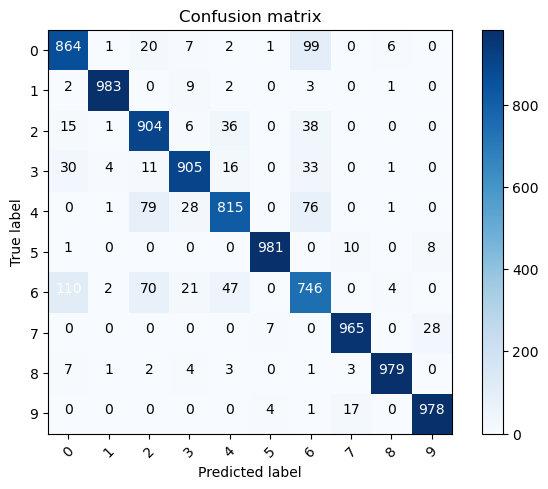

In [52]:

classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.jpg', format='jpg', dpi=300)

### <a name="17"></a> 17. Ocena modelu na zbiorze testowym

In [53]:
model = load_model('cnn_model.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9104 - loss: 0.0440
Test Loss: 0.042784783989191055
Test Accuracy: 0.9120000004768372
